### This notebook is to select final features using Pearson Correlation first

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor

import lightgbm as lgb

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cat
from catboost import CatBoostRegressor, cv, Pool


from feature_engine.categorical_encoders import CountFrequencyCategoricalEncoder
from feature_engine.outlier_removers import Winsorizer

# for Q-Q plots
import scipy.stats as stats

pd.set_option('display.max_rows',999)
pd.set_option('display.max_columns',50)

import warnings
warnings.filterwarnings("ignore")

In [2]:
trainset = pd.read_csv('trainfilled.csv')

In [3]:
trainset.shape

(1562, 40)

In [4]:
trainset.head()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876,408,24.583,397.410526,18.380,0.945945,0.010761,0.026038,0.005685,0.005635,0.0,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062,0.310,0.166,0.100,0.083326,0.262,0.342,11.022908,5.752414,21.715153,217,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577
1,10224,1166,28.346,3.000000,26.694,0.808959,0.002284,0.173426,0.001803,0.001493,0.0,0.012033,0.000000,7.714,0.545,0.040,0.324,0.201,0.253,0.102,0.066,0.070000,0.200,0.148,9.904099,5.752414,18.260000,181,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.396396,14.482893,3.013219,844
2,27023,2927,21.641,9.000000,31.028,0.956621,0.005141,0.013088,0.004728,0.004708,0.0,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032,0.296,0.215,0.087,0.070000,0.187,0.258,11.011502,5.752414,19.940000,234,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700
3,8735,1039,23.110,0.000000,27.734,0.894835,0.000298,0.076576,0.000995,0.004297,0.0,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084,0.255,0.182,0.104,0.081000,0.169,0.274,12.845770,5.752414,30.310000,231,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592
4,3681,365,21.985,2.000000,19.673,0.923886,0.000496,0.042889,0.000000,0.013622,0.0,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075,0.324,0.118,0.113,0.083326,0.178,0.340,11.565750,5.752414,21.715153,270,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444


In [5]:
trainset.describe()

,population,renter_occupied_households,pct_renter_occupied,evictions,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
count,1.562000e+03,1.562000e+03,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000,1562.000000
mean,1.083407e+05,1.490462e+04,28.525570,397.410526,28.537526,0.769045,0.088593,0.092012,0.018431,0.012709,0.000711,0.017583,0.000916,12.182780,0.470535,0.062551,0.220037,0.088844,0.304546,0.211682,0.106566,0.083326,0.164818,0.276981,11.637336,5.752414,21.715153,275.482714,3421.828611,2508.303867,0.499388,0.228672,0.167707,0.145666,0.346271,0.303030,0.205033,11.621356,10.415138,701.142125
std,3.745229e+05,6.255947e+04,8.121601,1353.939638,4.670467,0.203306,0.143505,0.141599,0.074762,0.026693,0.003059,0.015836,0.001657,5.783889,0.070936,0.022615,0.067456,0.041454,0.043522,0.059405,0.022506,0.020435,0.043197,0.053064,1.524285,2.691047,10.047720,57.827540,2443.369163,1887.374524,0.023918,0.034710,0.044527,0.067483,0.071152,0.052236,0.092001,2.756009,2.772070,192.883110
min,2.690000e+02,6.400000e+01,7.279000,-1.000000,9.909000,0.009547,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.186000,0.012000,0.053000,0.018000,0.133000,0.031000,0.033000,0.030000,0.032000,0.104000,7.209413,-0.080000,3.140000,76.000000,340.000000,279.000000,0.314000,0.082000,0.036000,0.019000,0.074297,0.114458,0.064128,3.654080,0.961076,351.000000
25%,1.045275e+04,1.078250e+03,22.874000,6.000000,25.869000,0.649967,0.005523,0.018747,0.001201,0.002391,0.000000,0.009465,0.000000,7.991000,0.425000,0.046000,0.172000,0.059000,0.283000,0.174000,0.092000,0.070000,0.144000,0.243000,10.443252,5.752414,14.935000,233.000000,1919.250000,1429.000000,0.495000,0.208000,0.140000,0.094226,0.300601,0.269461,0.142142,10.014818,8.613691,578.000000
50%,2.528200e+04,2.754000e+03,27.199500,72.500000,28.768000,0.846542,0.020599,0.037613,0.002610,0.005279,0.000000,0.014438,0.000302,11.173500,0.470500,0.061000,0.216000,0.079000,0.306000,0.211682,0.105000,0.080000,0.164818,0.281000,11.884105,5.752414,21.715153,270.000000,2889.500000,2080.000000,0.504000,0.227000,0.164500,0.129388,0.352176,0.303303,0.182365,11.435441,10.396898,650.000000
75%,6.836150e+04,7.987000e+03,32.341500,397.410526,31.307250,0.933479,0.102047,0.092998,0.006121,0.011886,0.000403,0.020999,0.001197,15.018500,0.515000,0.076000,0.265000,0.108750,0.331000,0.240000,0.121750,0.091000,0.182000,0.312000,12.879822,5.752414,26.015000,311.000000,3937.250000,2747.500000,0.511000,0.246000,0.191000,0.187719,0.396556,0.337672,0.241234,12.940235,12.250655,773.750000
max,1.002029e+07,1.760277e+06,73.008000,29251.000000,49.665000,0.995141,0.756011,0.987039,0.815817,0.418088,0.085037,0.184332,0.019582,38.792000,0.996000,0.242000,0.520000,0.327000,0.474000,0.513000,0.180000,0.182000,0.419000,0.446000,14.992477,26.920000,110.450000,511.000000,25169.000000,16740.000000,0.564000,0.415000,0.488000,0.535750,0.535536,0.477341,0.788153,29.034900,24.28115

In [6]:
trainset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1562 entries, 0 to 1561
Data columns (total 40 columns):
population                                    1562 non-null int64
renter_occupied_households                    1562 non-null int64
pct_renter_occupied                           1562 non-null float64
evictions                                     1562 non-null float64
rent_burden                                   1562 non-null float64
pct_white                                     1562 non-null float64
pct_af_am                                     1562 non-null float64
pct_hispanic                                  1562 non-null float64
pct_am_ind                                    1562 non-null float64
pct_asian                                     1562 non-null float64
pct_nh_pi                                     1562 non-null float64
pct_multiple                                  1562 non-null float64
pct_other                                     1562 non-null float64
poverty_rate 

### Drop Multicollinearity features

In [7]:
trainset1 = trainset.drop(labels=['renter_occupied_households','evictions'],axis=1)

In [8]:
trainset1.head()

,population,pct_renter_occupied,rent_burden,pct_white,pct_af_am,pct_hispanic,pct_am_ind,pct_asian,pct_nh_pi,pct_multiple,pct_other,poverty_rate,pct_civilian_labor,pct_unemployment,pct_uninsured_adults,pct_uninsured_children,pct_adult_obesity,pct_adult_smoking,pct_diabetes,pct_low_birthweight,pct_excessive_drinking,pct_physical_inactivity,air_pollution_particulate_matter_value,homicides_per_100k,motor_vehicle_crash_deaths_per_100k,heart_disease_mortality_per_100k,pop_per_dentist,pop_per_primary_care_physician,pct_female,pct_below_18_years_of_age,pct_aged_65_years_and_older,pct_adults_less_than_a_high_school_diploma,pct_adults_with_high_school_diploma,pct_adults_with_some_college,pct_adults_bachelors_or_higher,birth_rate_per_1k,death_rate_per_1k,gross_rent
0,3876,24.583,18.380,0.945945,0.010761,0.026038,0.005685,0.005635,0.0,0.005935,0.000000,4.172,0.550,0.023,0.107,0.062,0.310,0.166,0.100,0.083326,0.262,0.342,11.022908,5.752414,21.715153,217,3421.828611,2508.303867,0.471,0.218,0.190,0.083250,0.327984,0.389168,0.199599,10.008982,9.752342,577
1,10224,28.346,26.694,0.808959,0.002284,0.173426,0.001803,0.001493,0.0,0.012033,0.000000,7.714,0.545,0.040,0.324,0.201,0.253,0.102,0.066,0.070000,0.200,0.148,9.904099,5.752414,18.260000,181,2009.000000,1690.000000,0.472,0.290,0.077,0.099099,0.202202,0.302302,0.396396,14.482893,3.013219,844
2,27023,21.641,31.028,0.956621,0.005141,0.013088,0.004728,0.004708,0.0,0.014809,0.000905,9.789,0.508,0.063,0.129,0.032,0.296,0.215,0.087,0.070000,0.187,0.258,11.011502,5.752414,19.940000,234,4650.000000,1350.000000,0.496,0.208,0.192,0.137725,0.387226,0.255489,0.219561,9.620346,10.873572,700
3,8735,23.110,27.734,0.894835,0.000298,0.076576,0.000995,0.004297,0.0,0.022999,0.000000,13.735,0.545,0.038,0.207,0.084,0.255,0.182,0.104,0.081000,0.169,0.274,12.845770,5.752414,30.310000,231,4420.000000,1749.000000,0.503,0.193,0.215,0.077154,0.308617,0.398798,0.215431,9.383225,10.870809,592
4,3681,21.985,19.673,0.923886,0.000496,0.042889,0.000000,0.013622,0.0,0.016905,0.002202,8.217,0.474,0.034,0.177,0.075,0.324,0.118,0.113,0.083326,0.178,0.340,11.565750,5.752414,21.715153,270,3421.828611,1249.000000,0.516,0.222,0.230,0.092537,0.362189,0.346269,0.199005,9.543286,14.723926,444


In [9]:
trainset1.shape

(1562, 38)

### Select features that has positive correlation with gross_rent

In [10]:
pearson = trainset1[['population','pct_renter_occupied','rent_burden','pct_asian','pct_multiple','pct_other',
                     'pct_civilian_labor','pct_adults_bachelors_or_higher','gross_rent']]

In [11]:
pearson

,population,pct_renter_occupied,rent_burden,pct_asian,pct_multiple,pct_other,pct_civilian_labor,pct_adults_bachelors_or_higher,gross_rent
0,3876,24.583,18.380,0.005635,0.005935,0.000000,0.550,0.199599,577
1,10224,28.346,26.694,0.001493,0.012033,0.000000,0.545,0.396396,844
2,27023,21.641,31.028,0.004708,0.014809,0.000905,0.508,0.219561,700
3,8735,23.110,27.734,0.004297,0.022999,0.000000,0.545,0.215431,592
4,3681,21.985,19.673,0.013622,0.016905,0.002202,0.474,0.199005,444
...,...,...,...,...,...,...,...,...,...
1557,18983,22.621,26.905,0.012277,0.024815,0.000000,0.517,0.235944,928
1558,18837,28.649,26.515,0.020893,0.012667,0.000000,0.559,0.246507,640
1559,77224,18.928,28.827,0.012569,0.011835,0.000805,0.498,0.268195,754
1560,4698,20.107,48.980,0.000000,0.000000,0.000200,0.493,0.140000,640


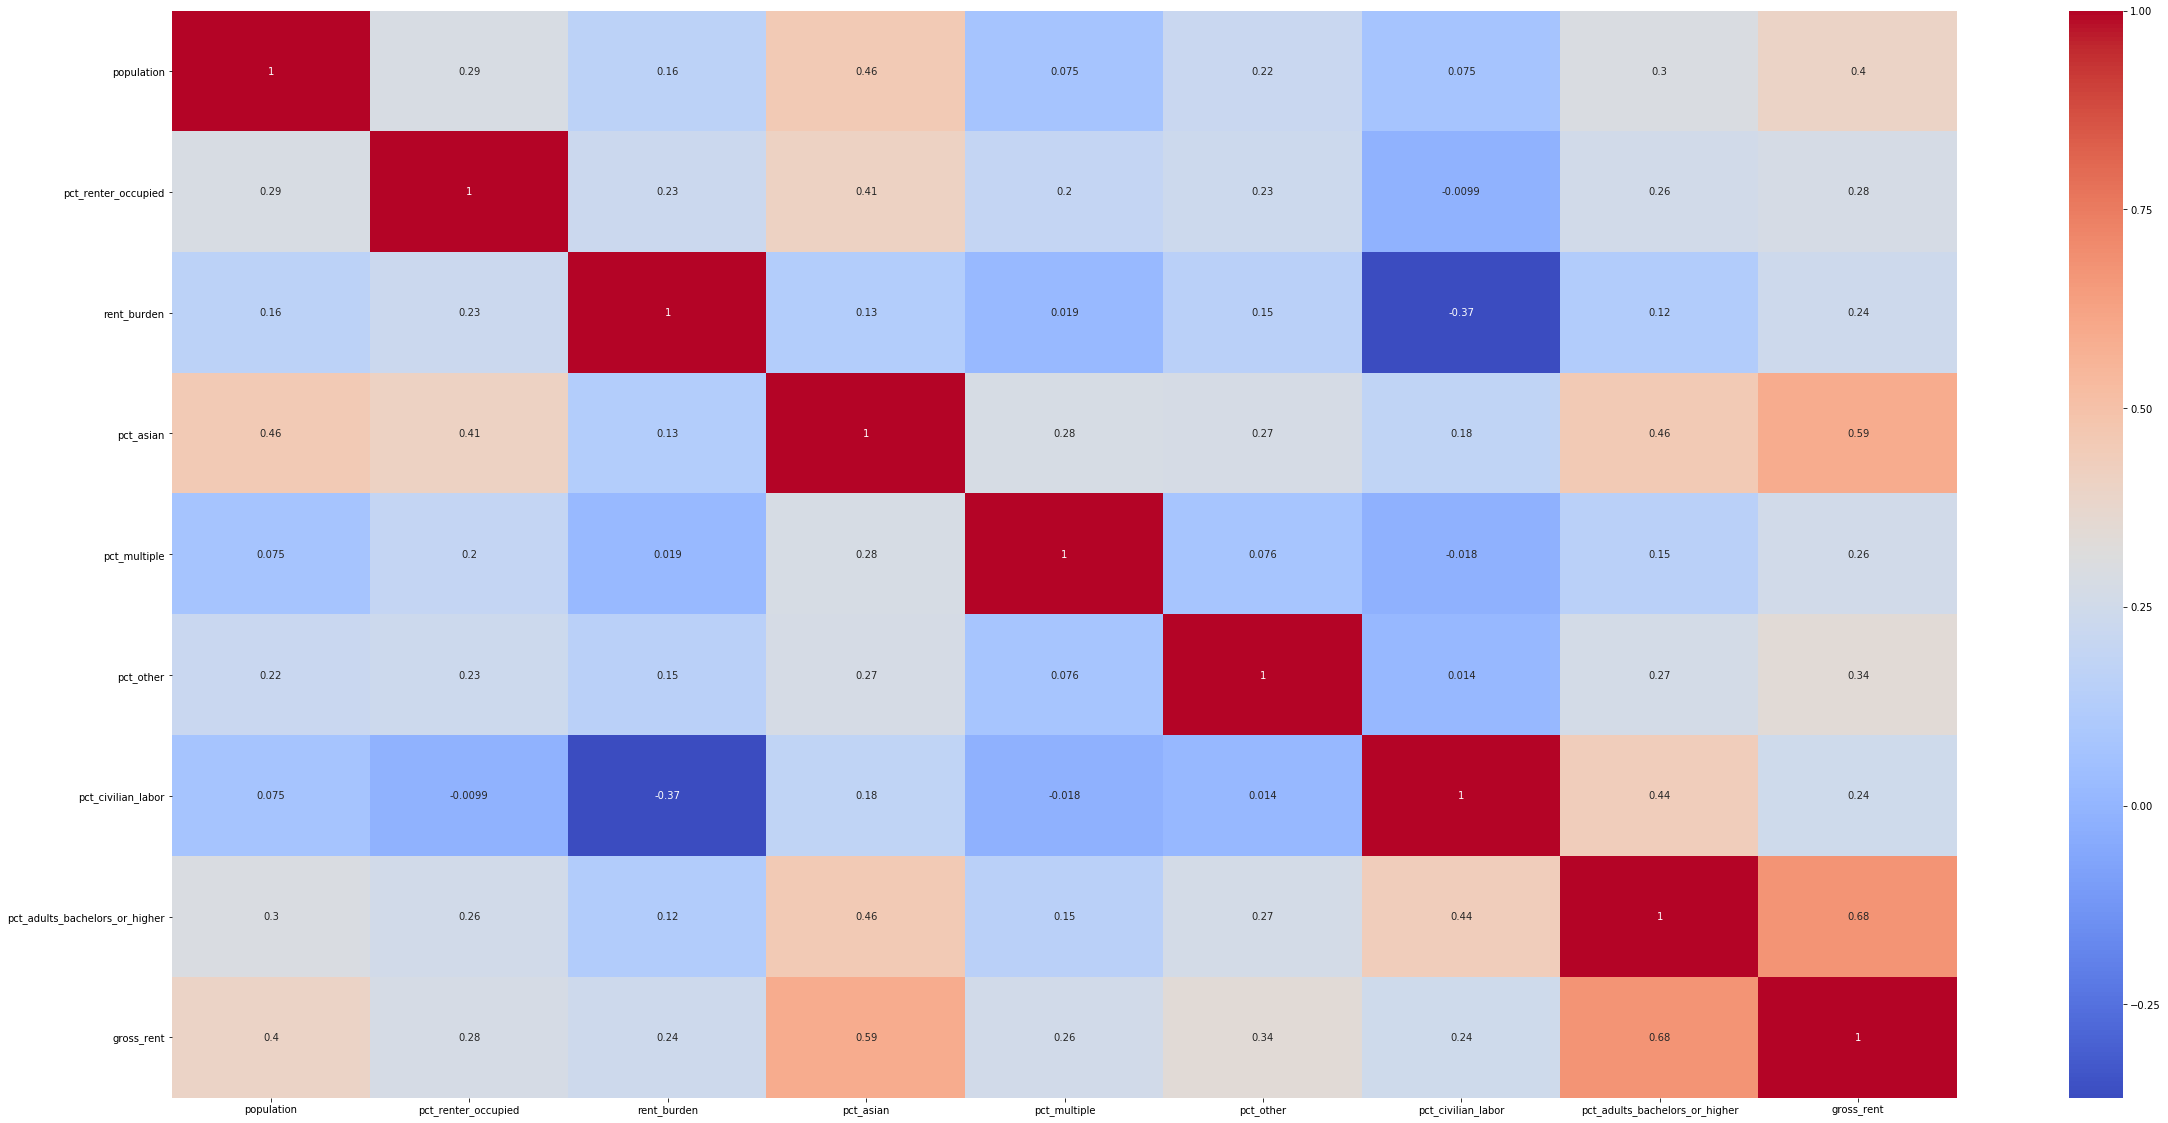

In [12]:
plt.figure(figsize=(40,20))
sns.heatmap(pearson.corr(method='pearson'),annot=True,cmap="coolwarm")
plt.show()

In [13]:
pearson.to_csv("pearsonselect.csv",index=False)

In [14]:
X_num = pearson.iloc[:,0:8]
y_num = pearson.iloc[:,8]

In [15]:
X_num.shape

(1562, 8)

In [16]:
y_num.shape

(1562,)

In [17]:
X_num.values

array([[3.87600000e+03, 2.45830000e+01, 1.83800000e+01, ...,
        0.00000000e+00, 5.50000000e-01, 1.99598796e-01],
       [1.02240000e+04, 2.83460000e+01, 2.66940000e+01, ...,
        0.00000000e+00, 5.45000000e-01, 3.96396396e-01],
       [2.70230000e+04, 2.16410000e+01, 3.10280000e+01, ...,
        9.05414000e-04, 5.08000000e-01, 2.19560878e-01],
       ...,
       [7.72240000e+04, 1.89280000e+01, 2.88270000e+01, ...,
        8.05088000e-04, 4.98000000e-01, 2.68195414e-01],
       [4.69800000e+03, 2.01070000e+01, 4.89800000e+01, ...,
        2.00298000e-04, 4.93000000e-01, 1.40000000e-01],
       [6.50813000e+05, 3.77890000e+01, 3.06870000e+01, ...,
        1.79886800e-03, 4.62000000e-01, 3.59281437e-01]])

In [18]:
y_num.values

array([577, 844, 700, ..., 754, 640, 976], dtype=int64)

### Tree Based Method Feature Selection

In [19]:
rf = RandomForestRegressor(n_estimators=100,criterion='mae',n_jobs=-1)

In [20]:
rfFit = rf.fit(X_num,y_num)

In [21]:
print(rfFit.feature_importances_)

[0.21513377 0.09032703 0.08025678 0.17691042 0.08121023 0.06364446
 0.07433632 0.218181  ]


In [22]:
colname = pd.DataFrame(trainset1.columns, columns=['Name'])

In [23]:
colname.head()

,Name
0,population
1,pct_renter_occupied
2,rent_burden
3,pct_white
4,pct_af_am


In [24]:
result = pd.DataFrame(rfFit.feature_importances_,columns=['result'])

In [25]:
result.head()

,result
0,0.215134
1,0.090327
2,0.080257
3,0.176910
4,0.081210


In [26]:
combined = pd.concat([colname,result],axis=1)

In [27]:
combined.sort_values(by='result')

,Name,result
5,pct_hispanic,0.063644
6,pct_am_ind,0.074336
2,rent_burden,0.080257
4,pct_af_am,0.081210
1,pct_renter_occupied,0.090327
3,pct_white,0.176910
0,population,0.215134
7,pct_asian,0.218181
8,pct_nh_pi,NaN
9,pct_multiple,NaN


**Significant feature = 'population', 'pct_adults_bachelors_or_higher','pct_asian','death_rate_per_1k', 
poverty_rate, pct_adult_obesity, pct_aged_65_years_and_older **

In [28]:
et = ExtraTreesRegressor(n_estimators=100,criterion='mae',n_jobs=-1)
etFit = et.fit(X_num,y_num)

In [29]:
etFit.feature_importances_

array([0.14591019, 0.09442845, 0.0919199 , 0.17211456, 0.08805647,
       0.08193214, 0.08328772, 0.24235057])

In [30]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [31]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [32]:
result = pd.DataFrame(etFit.feature_importances_,columns=['Result'])

In [33]:
result.head()

,Result
0,0.145910
1,0.094428
2,0.091920
3,0.172115
4,0.088056


In [34]:
combined = pd.concat([colname,result],axis=1)

In [35]:
combined.sort_values(by='Result')

,Name,Result
5,pct_white,0.081932
6,pct_af_am,0.083288
4,rent_burden,0.088056
2,pct_renter_occupied,0.091920
1,renter_occupied_households,0.094428
0,population,0.145910
3,evictions,0.172115
7,pct_hispanic,0.242351
8,pct_am_ind,NaN
9,pct_asian,NaN


**Significant Features = pct_adults_bachelors_or_higher, pct_asian, population, death_rate_per_1k,
renter_occupied_households, pct_adults_with_high_school_diploma, poverty_rate **

### Using LightGBM

In [36]:
trainingdata = lgb.Dataset(data=X_num, label=y_num)
params = {}
params['learning_rate'] = 0.1
params['boosting_type'] = 'gbdt'
params['objective'] = 'regression'
params['metric'] = ['mean_absolute_error']

lgbmodel = lgb.train(params=params,train_set=trainingdata,num_boost_round=100)

In [37]:
lgbmodel.feature_importance()

array([407, 418, 386, 409, 349, 242, 377, 412])

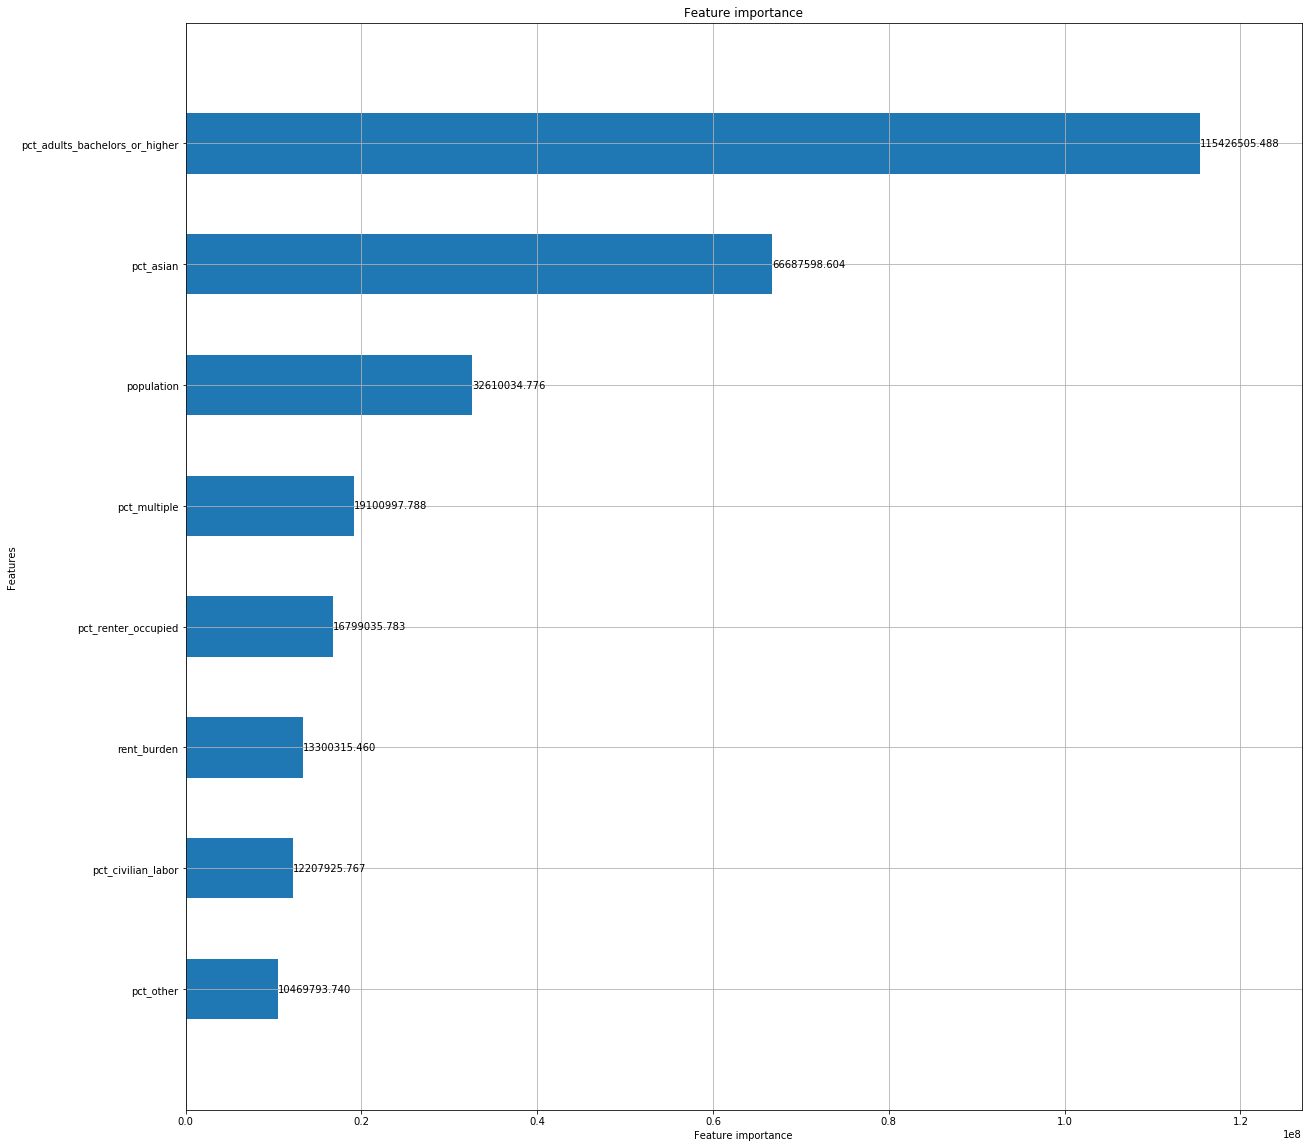

In [38]:
lgb.plot_importance(lgbmodel,height=0.5, figsize=(20,20), importance_type='gain')
plt.show()

In [39]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [40]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [41]:
result = pd.DataFrame(lgbmodel.feature_importance(),columns=['Result'])

In [42]:
result.head()

,Result
0,407
1,418
2,386
3,409
4,349


In [43]:
combined = pd.concat([colname,result], axis=1)

In [44]:
combined.sort_values(by='Result')

,Name,Result
5,pct_white,242.0
4,rent_burden,349.0
6,pct_af_am,377.0
2,pct_renter_occupied,386.0
0,population,407.0
3,evictions,409.0
7,pct_hispanic,412.0
1,renter_occupied_households,418.0
8,pct_am_ind,NaN
9,pct_asian,NaN


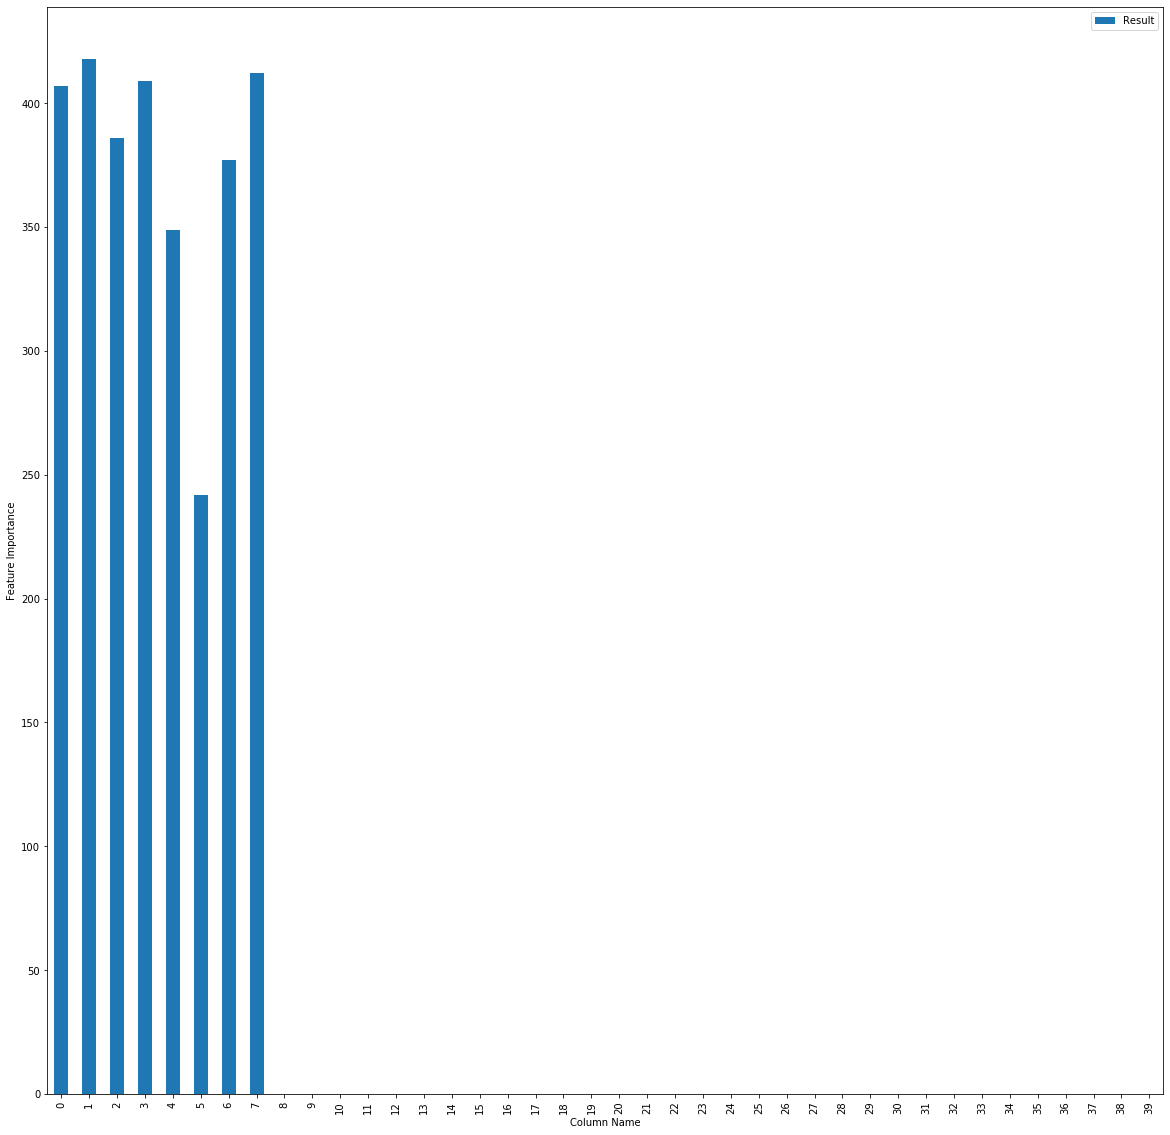

In [45]:
combined.plot(kind='bar',figsize=(20,20))
plt.xlabel("Column Name")
plt.ylabel("Feature Importance")
plt.show()

**Significant features = pct_adults_bachelors_or_higher, pct_asian, poverty_rate, population,
pct_adult_obesity,death_rate_per_1k, pct_white **

### Using XGBoost

In [46]:
xgbreg = xgb.XGBRegressor(objective ='reg:squarederror')
xgbreg.fit(X_num,y_num)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [47]:
print(xgbreg.feature_importances_)

[0.1056689  0.03211937 0.03222182 0.26063272 0.05856413 0.05310006
 0.04396302 0.41373008]


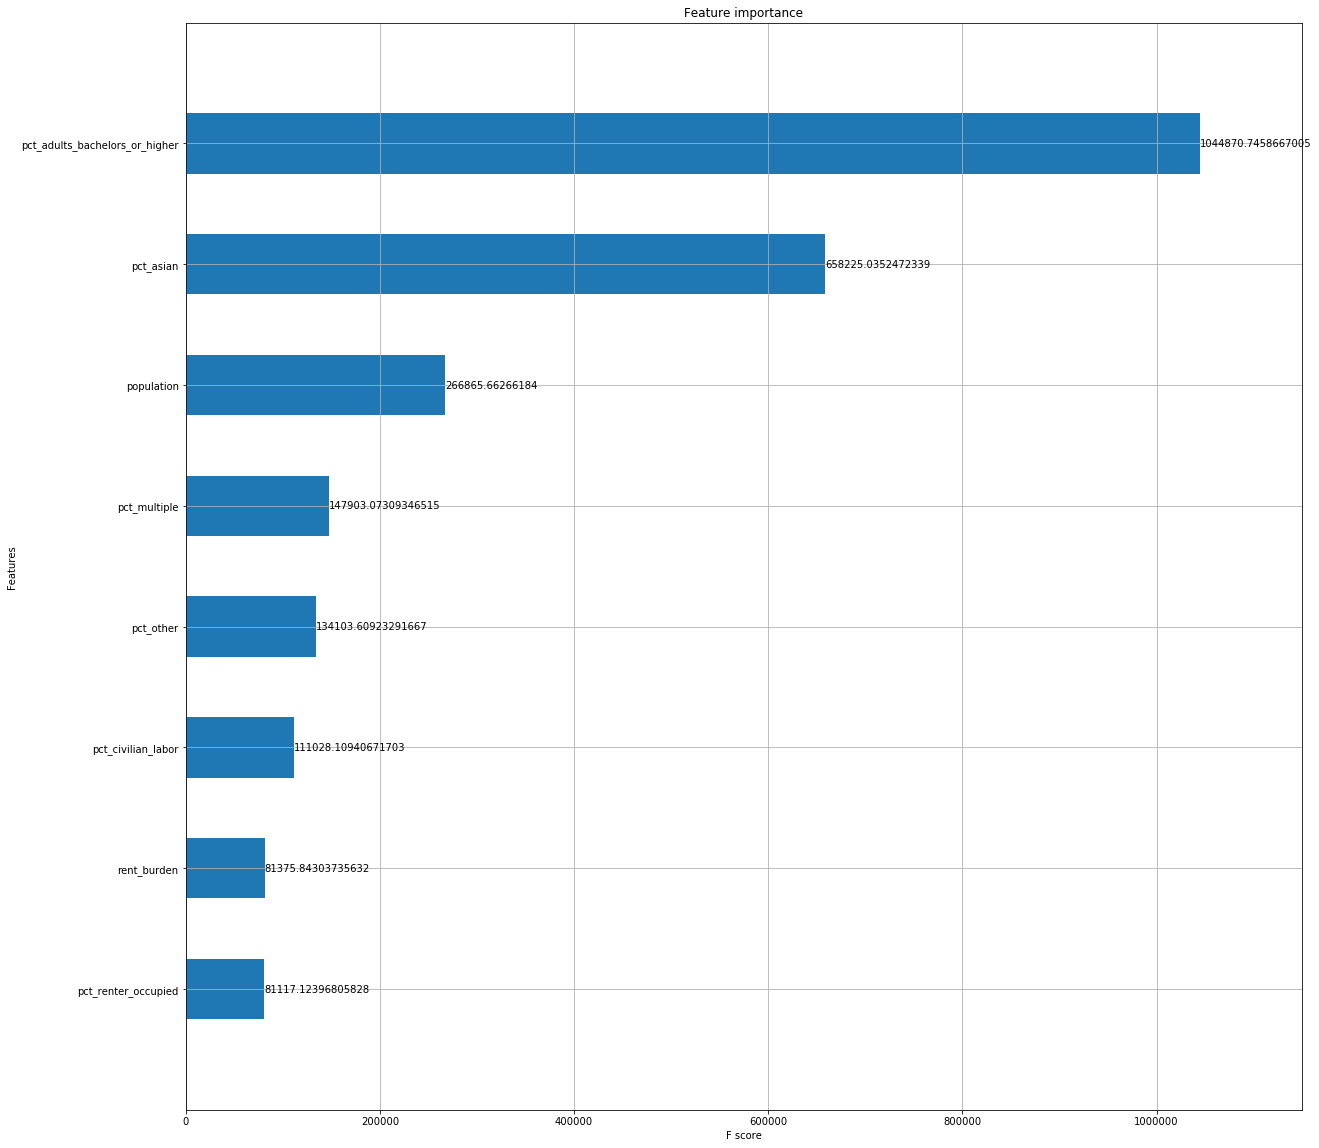

In [48]:
ax = xgb.plot_importance(xgbreg,height=0.5,importance_type='gain')
fig = ax.figure
fig.set_size_inches(20,20)

In [49]:
colname = pd.DataFrame(trainset.columns, columns=['Name'])

In [50]:
colname.head()

,Name
0,population
1,renter_occupied_households
2,pct_renter_occupied
3,evictions
4,rent_burden


In [51]:
result = pd.DataFrame(xgbreg.feature_importances_, columns=['Result'])

In [52]:
result.head()

,Result
0,0.105669
1,0.032119
2,0.032222
3,0.260633
4,0.058564


In [53]:
combined = pd.concat([colname,result], axis=1)

In [54]:
combined.sort_values(by='Result')

,Name,Result
1,renter_occupied_households,0.032119
2,pct_renter_occupied,0.032222
6,pct_af_am,0.043963
5,pct_white,0.053100
4,rent_burden,0.058564
0,population,0.105669
3,evictions,0.260633
7,pct_hispanic,0.413730
8,pct_am_ind,NaN
9,pct_asian,NaN


**Significant Features: pct_adults_bachelors_or_higher, pct_asian, pct_adults_with_high_school_diploma, 
population, pct_adult_obesity, death_rate_per_1k, pct_physical_inactivity  **

### Using Catboost

In [55]:
#Define a Pool Dataset
trainpool = Pool(data=X_num,label=y_num)

In [56]:
catreg = cat.CatBoostRegressor(iterations=100,loss_function='MAE')
catreg.fit(X_num,y_num)

0:	learn: 132.1305185	total: 160ms	remaining: 15.8s
1:	learn: 130.0079782	total: 165ms	remaining: 8.08s
2:	learn: 127.9074569	total: 171ms	remaining: 5.54s
3:	learn: 125.9898145	total: 175ms	remaining: 4.21s
4:	learn: 124.0221981	total: 180ms	remaining: 3.42s
5:	learn: 122.1596490	total: 188ms	remaining: 2.94s
6:	learn: 120.4436363	total: 191ms	remaining: 2.54s
7:	learn: 118.7619352	total: 193ms	remaining: 2.22s
8:	learn: 117.2207549	total: 196ms	remaining: 1.98s
9:	learn: 115.6508258	total: 200ms	remaining: 1.8s
10:	learn: 114.2283214	total: 204ms	remaining: 1.65s
11:	learn: 112.7418687	total: 207ms	remaining: 1.52s
12:	learn: 111.2962333	total: 210ms	remaining: 1.4s
13:	learn: 110.0075086	total: 212ms	remaining: 1.3s
14:	learn: 108.8767804	total: 217ms	remaining: 1.23s
15:	learn: 107.6531990	total: 220ms	remaining: 1.15s
16:	learn: 106.6859741	total: 223ms	remaining: 1.09s
17:	learn: 105.4293643	total: 225ms	remaining: 1.03s
18:	learn: 104.3319153	total: 228ms	remaining: 972ms
19:	le

In [57]:
catreg.get_feature_importance(type='PredictionValuesChange')

array([17.53521185,  8.04813496,  7.22122889, 20.92007721,  8.07445032,
        7.66233298,  6.94003566, 23.59852813])

In [58]:
colname = pd.DataFrame(pearson.columns, columns=['Name'])

In [59]:
colname.head()

,Name
0,population
1,pct_renter_occupied
2,rent_burden
3,pct_asian
4,pct_multiple


In [60]:
result = pd.DataFrame(catreg.feature_importances_, columns=['Result'])

In [61]:
result.head()

,Result
0,17.535212
1,8.048135
2,7.221229
3,20.920077
4,8.074450


In [62]:
combined = pd.concat([colname,result], axis=1)

In [63]:
combined.sort_values(by='Result')

,Name,Result
6,pct_civilian_labor,6.940036
2,rent_burden,7.221229
5,pct_other,7.662333
1,pct_renter_occupied,8.048135
4,pct_multiple,8.074450
0,population,17.535212
3,pct_asian,20.920077
7,pct_adults_bachelors_or_higher,23.598528
8,gross_rent,NaN


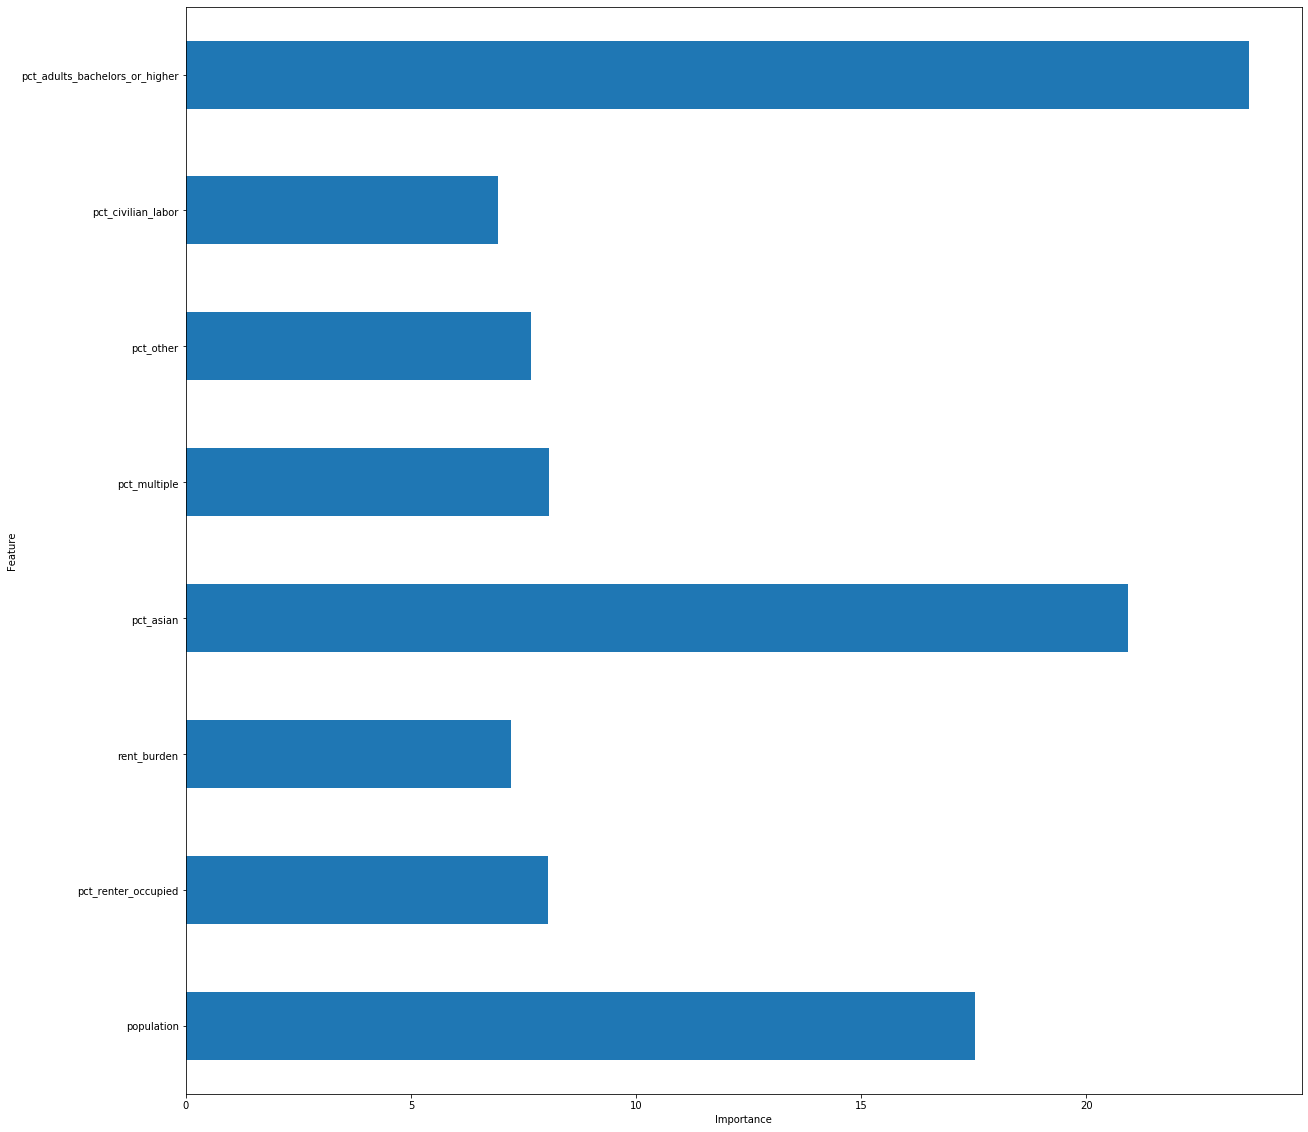

In [64]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.feature_importances_,index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

**Significant features: pct_adults_bachelors_or_higher,death_rate_per_1k, population, poverty rate, pct_hispanic,  
pct_physical_inactivity, renter_occupied_households, pct_asian **

In [65]:
catreg.get_feature_importance(data=trainpool,type='LossFunctionChange')

array([11.10611968,  1.60491587,  2.57405035,  9.67712088,  3.31784169,
        2.84595111,  3.61597732, 15.20298292])

In [66]:
result2 = pd.DataFrame(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), columns=['LossFunction'])

In [67]:
result2

,LossFunction
0,11.106120
1,1.604916
2,2.574050
3,9.677121
4,3.317842
5,2.845951
6,3.615977
7,15.202983


In [68]:
combined2 = pd.concat([colname,result2], axis=1)

In [69]:
combined3 = combined2.sort_values(by='LossFunction')

In [70]:
combined3

,Name,LossFunction
1,pct_renter_occupied,1.604916
2,rent_burden,2.574050
5,pct_other,2.845951
4,pct_multiple,3.317842
6,pct_civilian_labor,3.615977
3,pct_asian,9.677121
0,population,11.106120
7,pct_adults_bachelors_or_higher,15.202983
8,gross_rent,NaN


**Significant features: death_rate_per_1k, poverty rate, population, pct_adults_bachelors_or_higher, 
pct_asian, pct_hispanic, pct_physical_inactivity **

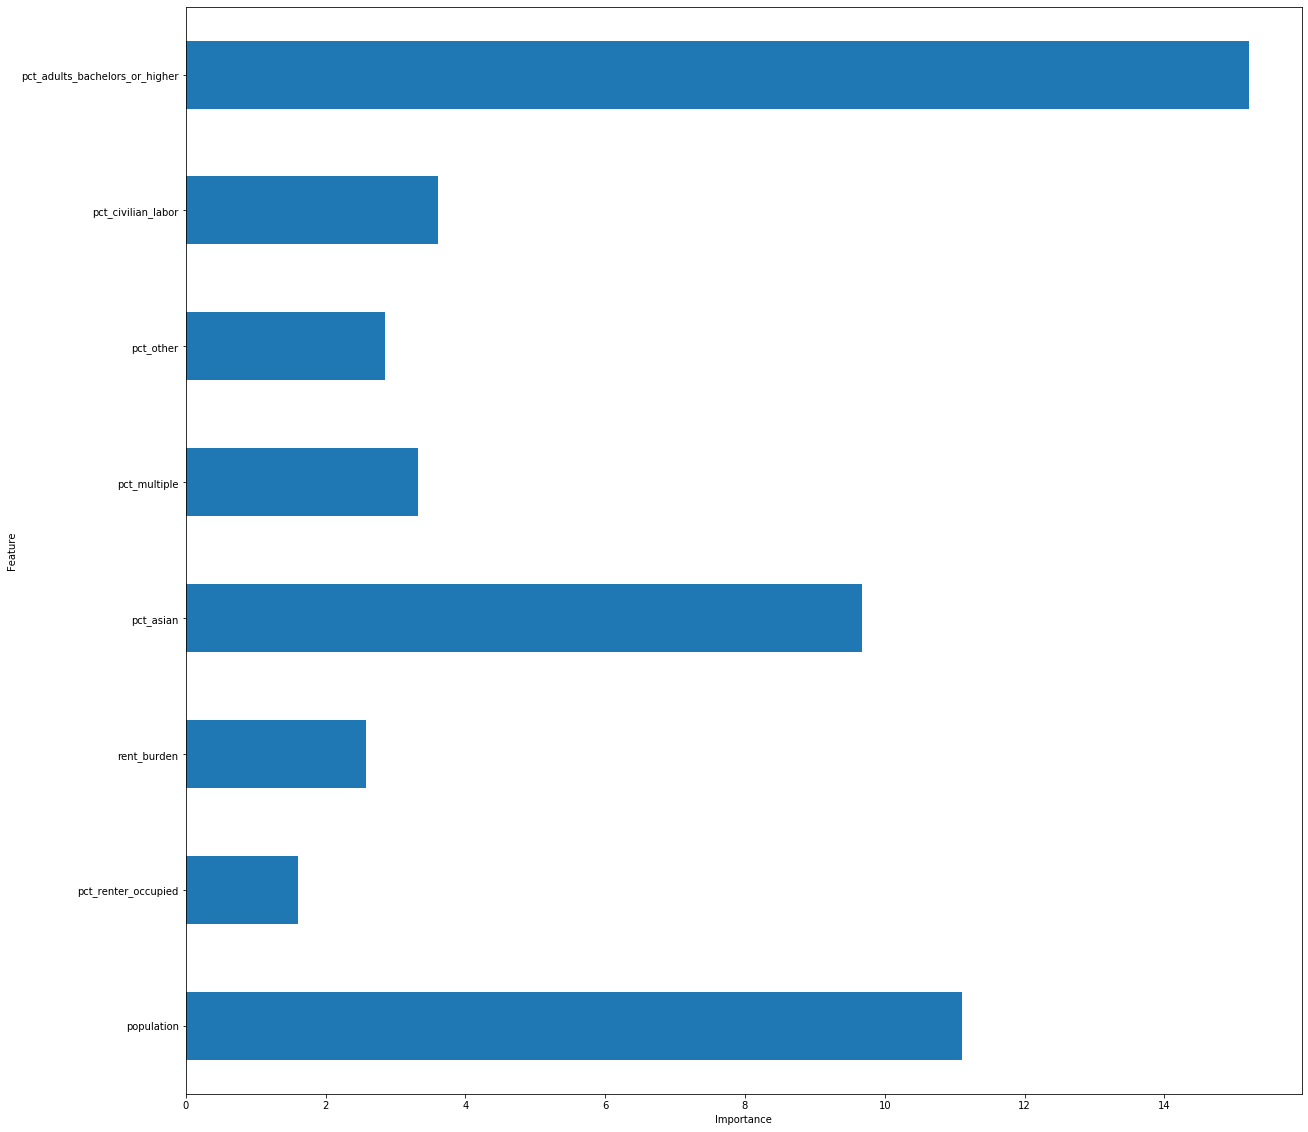

In [71]:
plt.figure(figsize=(20,20))
feat_importances = pd.Series(catreg.get_feature_importance(data=trainpool,type='LossFunctionChange'), index=X_num.columns)
feat_importances.plot(kind='barh')
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()

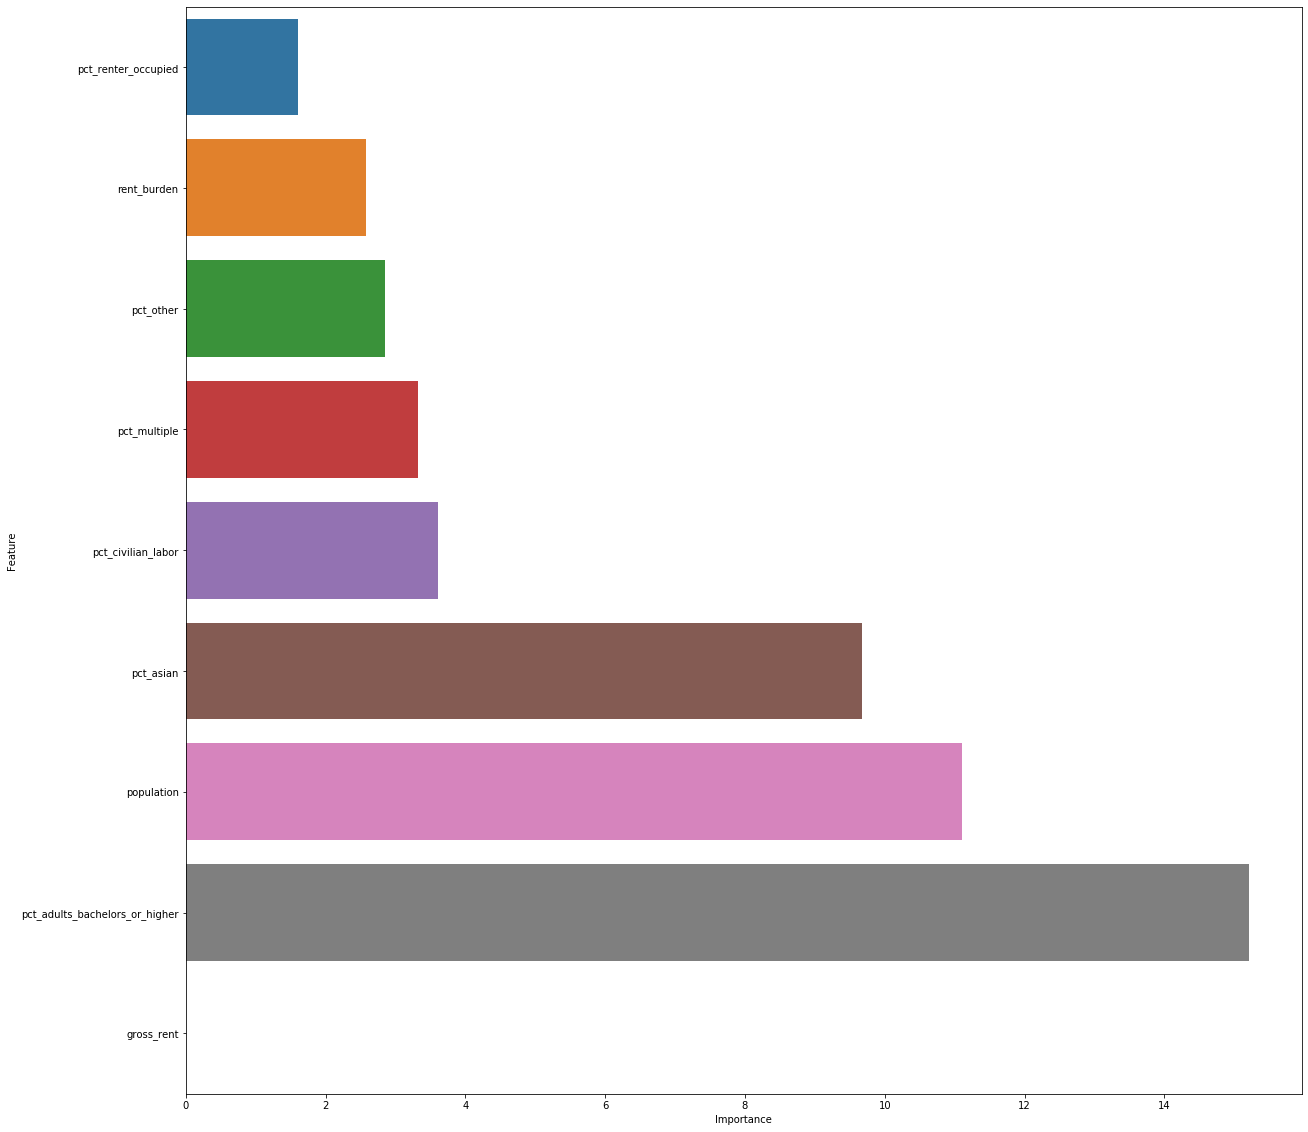

In [72]:
plt.figure(figsize=(20,20))
sns.barplot(x=combined3.LossFunction,y=combined3.Name)
plt.ylabel('Feature')
plt.xlabel('Importance')
plt.show()